# DC resistivity over TKC


## Purpose

Understand basic setup and physics of a direct current (DC) resistivity
survey within the context of a kimberlite exploration. Run DC forward
modelling and inversion using SimPEG-Static package.

<img src="../../../images/tkc/dc.png" alt="Scipy_2016_PF_Thumbnail" width="400px">


## Set-up

The physical behavior of DC resistivity survey is governed by the steady-state
Maxwell's equations:

$$
\vec{j} = \sigma \vec{e}
$$

$$
\vec{e} = -\nabla \phi
$$

$$
\nabla \cdot \vec{j} = -\nabla \cdot \vec{j}_s = I_0 (\delta(\vec{r}-\vec{r}_+)-\delta(\vec{r}-\vec{r}_-))
$$

$$
\vec{j} \cdot \hat{n} \ \Big|_{\partial \Omega} = 0
$$

where:
- $\vec{j}$: Current density (A/m $^2$)

- $\vec{e}$: Electric field (V/m)

- $I_0$: Current (A)

- $\delta$: Volumetric delta function ($m^{-3}$)

Consider a simple gradient array having a pair of A (+) and B (+) current
electrodes (Tx) with multiple M (+) and N (-) potential electrodes (Rx). Using
giant battery (?), we setup a significant potential difference allowing
electrical currents to flow between the A to B electrodes. If the earth
includes conductors or resistors, these will distorts current flow, and
measured potential differences on the surface electrodes (MN) will be
reflective of those distortions. Typically kimberlitic pipes (including those
containing diamonds!) will be more conductive than the background rock
(granitic), hence, the measured potential difference will be low. That is,
contrasts in electrical conductivity between different rocks induce anomalous
voltages. From the observed voltages, we want to estimate conductivity
distribution of the earth. We use a geophysical inversion technique to do this
procedure.

We work through each step of geophysical inversion using [SimPEG-Static
package](http://docs.simpeg.xyz/content/dc/index.html) under SimPEG's
framework having two main items: a) Forward simulation and b) Inversion.

<img src="../../../images/SimPEGFramework.png" alt="SimPEGframework" width="400px">

## Forward simulation


A forward simulation of a DC experiment requires [Survey](
http://docs.simpeg.xyz/content/api_core/api_ForwardProblem.html?#survey)
and [Problem](http://docs.simpeg.xyz/content/api_core/api_ForwardProblem.html
?#problem-class) classes. We need to the pass current and potential
electrode locations to a DC survey class. The physical behavior of DC fields
and fluxes are governed by the static Maxwell's equations. To numerically
work with these equations, we use the DC problem class, which handles this by solving a
corresponding partial different equation in a discrete space. For this, the
earth needs to be discretized to solve corresponding partial
differential equation. The Problem class computes fields in full discretized
domain, and the Survey class evaluates data at potential electrodes using the
fields. The Survey and Problem classes need to share information hence, we
pair them.


### Mesh

We use a 3D tensor mesh to discretize the earth having 25x25x25 m core cell
size. Smaller vertical size of the cell (dz) is used close to the topographic
surface (12.5 m), and padding cells are used to satisfies the natural boundary
condition imposed.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from SimPEG import (
    Mesh, Maps, Utils, DataMisfit, Regularization, Optimization,
    InvProblem, Inversion, Directives
)
from SimPEG.EM.Static import DC

try:
    from pymatsolver import Pardiso as Solver
except:
    from SimPEG import SolverLU as Solver

%matplotlib inline

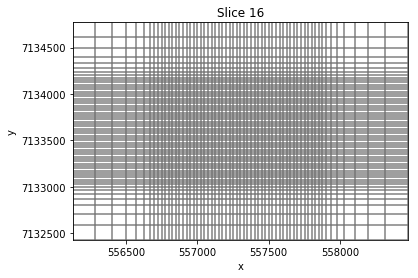

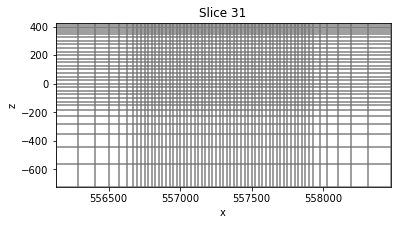

In [5]:
# Core cell sizes in x, y, and z
csx, csy, csz = 25., 25., 25.

# Number of core cells in each directiPon s
ncx, ncy, ncz = 48, 48, 20

# Number of padding cells to add in each direction
npad = 7

# Vectors of cell lengthts in each direction
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]

# Create mesh
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")

# Map mesh coordinates from local to UTM coordiantes
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.
mesh._x0 = mesh.x0 + np.r_[xc, yc, zc]

# plot the mesh
mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="Y")
plt.gca().set_aspect('equal')
plt.show()

### Survey

We use a simple gradient array having a pair of current electrodes (AB), and
multiple potential electrodes (MN).  The lengths of AB and MN electrodes are
1200 and 25 m, respectively.

![Gradient array](../../../images/dc/GradientArray.png)


Once we have obtained locations of AB (Src) and MN (Rx) electrodes, we can
generate **Survey** class:

In [6]:
# Create Src and Rx classes for DC problem
Aloc1_x = np.r_[-600., 0, 0.] + np.r_[xc, yc, zc]
Bloc1_x = np.r_[600., 0, 0.] + np.r_[xc, yc, zc]

# Rx locations (M-N electrodes, x-direction)
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300.+ xc, mesh.vectorCCx<300.+ xc)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300.+ yc, mesh.vectorCCy<300.+ yc)]
# Grid selected cell centres to get M and N Rx electrode locations
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])

rx = DC.Rx.Dipole(Mx, Nx)
src = DC.Src.Dipole([rx], Aloc1_x, Bloc1_x)

# Form survey object using Srcs and Rxs that we have generated
survey = DC.Survey([src])

### Fields and Data

By solving the DC equations, we compute electrical potential ($\phi$) at
every cell. The **Problem** class does this, but it still requires survey
information hence we pair it to the **Survey** class:

In [9]:
# Define problem and set solver
problem = DC.Problem3D_CC(mesh)

problem.Solver = Solver
# Pair problem and survey
problem.pair(survey)

Here, we used ``DC.Problem3D_CC``, which means 3D space and $\phi$ is
defined at the cell center. Now, we are ready to run DC forward modelling! For
this modelling, inside of the code, there are two steps:

1. Compute fields ($\phi$ at every cells)
2. Evaluate at Rx location (potential difference at MN electrodes)

Consider two conductivity models:

- Homogeneous background below topographic surface: ``sigma0``
  ($10^{-4}$ S/m)

- Includes diamond pipes: ``sigma`` (S/m)

In [10]:
# Read pre-generated conductivity model in UBC format
sigma = mesh.readModelUBC("VTKout_DC.dat")
# Identify air cells in the model
airind = sigma == 1e-8
# Generate background model (constant conductiivty below topography)
sigma0 = np.ones_like(sigma)*1e-4
sigma0[airind] = 1e-8

IOError: [Errno 2] No such file or directory: 'VTKout_DC.dat'

In [ ]:
# Forward model fields due to the reference model and true model
f0 = problem.fields(sigma0)
f = problem.fields(sigma)

Now ``f`` and ``f0`` are **Field** objects including computed $\phi$
everywhere. However, this **Field** object know how to compute both
$\vec{e}$, $\vec{j}$, and electrical charge, $\int_V \rho_v
dV$ ($\rho_v$ is volumetric charge density). Note that if we know
$\phi$, all of them can be computed for a corresponding source:

In [12]:
phi = f[src, 'phi']
e = f[src, 'e']
j = f[src, 'j']
charge = f[src, 'charge']

NameError: name 'f' is not defined

Since the field object for the background model is generic, we can obtain
secondary potential:

In [ ]:
# Secondary potential
phi0 = f0[src, 'phi']
phi_sec = phi - phi0

We present plan and section views of currents, charges, and secondary
potentials in the figure below (Left, middle, and right panels show currents, charges, and secondary potentials)

![DCfields](../../../images/dc/DCfields.png)

Current flows from A (+) to B (-) electrode (left to right). Kimberlite pipe
should be more conductive than the background considering more currents are
flowing through the pipe (See distortions of the current path in the left
panel).

The distribution of electrical charges (the middle panel) supports that the
pipe is conductive since left and right side of the pipe has negative and
positive charges, respectively. In addition, charges only built on the
boundary of the conductive pipe.

The secondary potential (the right panel) is important since it shows response
from the kimberlite pipe, which often called "Anomalous potential". Usually,
removing background response is a good way to see how much anomalous response
could be obtained for the target.

On the other hand, we cannot measure those fields everywhere but measure
potential differences at MN electrodes (Rx) hence we need to evaluate them
from the fields:

In [13]:
# Get observed data
dobs = survey.dpred(sigma, f=f)

NameError: name 'sigma' is not defined

If the field has not been computed then we do:

In [14]:
# Get observed data
dobs = survey.dpred(sigma)

NameError: name 'sigma' is not defined

This will compute the field inside of the code then evaluate for data at Rx
locations. Below image shows the computed DC data. Smaller potentials are
obtained at the center locations, which implies the existence of conductive
materials. Current easily flows with conductive materials, which means less
potential is required to path through them, hence for resistive materials we
get greater potential difference measured on the surface. The measured
potential provides some idea of the earth; however, this is not enough, we
want a 3D distribution of the conductivity!

![DCdata](../../../images/dc/DCdata.png)

## Inversion Elements

Our goal here is finding a 3D conductivity model which explains the observed
data shown above. Inversion elements (red box in the
[SimPEG Framework](#Set-up)) will handle this task with an ability to simulate
forward problem. We go through each element and briefly explain.

### Mapping

For the simulation, we used a 3D conductivity model, with a value defined in
every cell center location. However, for the inversion, we may not want to
estimate conductivity at every cell. For instance, our domain include some air
cells, and we already know well about the conductivity of the air
($10^{-8} \approx 0$) hence, those air cell should be excluded from the
inversion model, $m$. Accordingly, a mapping is required moving from the
inversion model to conductivity model defined at whole discrete domain:

$$
    \sigma  = \mathcal{M}(m)
$$

In addition, conductivity is strictly positive and varies logarithmically, so
we often use log conductivity as our inversion model ($m = log
(\sigma)$). Our inversion model is log conductivity only defined below the
subsurface cells, and this can be expressed as

$$
    \sigma = \mathcal{M}_{exp}\Big(\mathcal{M}_{act} (m)\Big),
$$

where $\mathcal{M}_{act}(\cdot)$ is a `InjectActiveCells` map, which
takes subsurface cell and surject to full domain including air cells, and
$\mathcal{M}_{exp}(\cdot)$ is an `ExpMap` map takes log conductivity
to conductivity. Combination of two maps are required to get $\sigma$
from $m$, which can be codified as

In [15]:
# from log conductivity to conductivity
expmap = Maps.ExpMap(mesh)
# from subsurface cells to full 3D cells
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8))
mapping = expmap*actmap

NameError: name 'Maps' is not defined

Generated mapping should be passed to **Problem** class:

In [16]:
# Generate problem with mapping
problem = DC.Problem3D_CC(mesh, sigmaMap=mapping)

NameError: name 'mapping' is not defined

### Data Misfit

Finding a model explaining the observed data requires a measure between
observed ($\mathbf{d}^{obs}$) and predicted data
($\mathbf{d}^{dpred}$):

$$
    \phi_d = 0.5\| \mathbf{W}_d (\mathbf{d}^{pred}-\mathbf{d}^{obs})\|^2_2,
$$

where $\mathbf{W}_d = \mathbf{diag}( \frac{1}{\% | \mathbf{d}^{obs}
|+\epsilon} )$ is the data weighting matrix. Uncertainty in the observed data
is approximated as $\% | \mathbf{d}^{obs} |+\epsilon$.

In [17]:
# percentage and floor for uncertainty in the observed data
std, eps = 0.05, 1e-3
survey.std = std
survey.eps = eps
survey.dobs = dobs

# Define datamisfit portion of objective function
dmisfit = DataMisfit.l2_DataMisfit(survey)


NameError: name 'dobs' is not defined

### Regularization

The objective function includes both data misfit and regularization terms,
$\phi_m$ :

$$
    \phi = \phi_d + \beta \phi_m
$$

We use Tikhonov-style regularization including both smoothness and smallness
terms. For further details of this See XXX.

In addition, considering the geometry of the gradient array: a single source
and distributed receivers, this specific DC survey may not have much depth
resolution similar to magnetic and gravity data. Depth weighting
($\frac{1}{(z-z_0)^3}$) is often used to handle this. And with this
weight we form **Regularization** class:

In [18]:
# Depth weighting
depth = 1./(abs(mesh.gridCC[:,2]-zc))**1.5
depth = depth/depth.max()

# Define regulatization (model objective function)
reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
reg.cell_weights = depth[~airind]
reg.alpha_s = 1e-1
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.

NameError: name 'Regularization' is not defined

### Optimization

To minimize the objective function, an optimization scheme is required. The
**Optimization** class handles this, and we use Inexact Gauss Newton Scheme
CITExxx.

In [19]:
opt = Optimization.InexactGaussNewton(maxIter = 20)

NameError: name 'Optimization' is not defined

### InvProblem

Both **DatamMisfit** and **Regularization** classes are created, and an
**Optimization** is chosen. To pose the inverse problem, they need to be
declared as an optimization problem:

$$
    \text{minimize} \ \phi_d + \beta \phi_m \ \\
    s.t. \ \text{some constratins}
$$

The **InvProblem** class can be set with **DatamMisfit**,  **Regularization** and **Optimiztion**
classes.

In [ ]:
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

### Inversion

We have stated our inverse problem, but a conductor is required, who directs
our inverse problem. **Directives** conducts our **Inversion**. For instance,
the trade-off parameter, $\beta$ needs to be estimated, and sometimes
cooled in the inversion iterations. A target misfit is need to be set usually
upon discrepancy principle ($\phi_d^\ast = 0.5 N_d$, where $N_d$
is the number of data).


In [21]:
# Define Directives
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
target = Directives.TargetMisfit()

# Define Inversion class
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])

NameError: name 'invProb' is not defined

### Run

Now we all set. The initial model is assumed to be homogeneous.

In [23]:
# Create inital and reference model (1e-4 S/m)
m0 = np.ones(mesh.nC)[~airind]*np.log(1e-4)

# Run inversion
mopt = inv.run(m0)

NameError: name 'airind' is not defined


The inversion runs and reaches to the target misfit, hence we fit the observed
data.

![DCObsPred](../../../images/dc/DCObsPred.png)

A 3D conductivity model is recovered and compared with the true conductivity
model. A conductive pipe at depth is recovered!

![DCObsPred](../../../images/dc/Cond3D.png)
